# <center> <font color='blue'> <b> LINEAR REGRESSION </b> </font> </center>

TABLE OF CONTENT

....

## 1. Libraries

In [37]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import warnings
warnings.filterwarnings('ignore')

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Load data

In [7]:
!ls data

'Salary Data.csv'


In [69]:
df = pd.read_csv('data/Salary Data.csv')


df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


We are going to predict the salary using only the "years of experience"

In [70]:
df.shape

(375, 6)

In [71]:
df.columns

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object')

In [82]:
# check for nan values

total_nan_values = df.isnull().sum().sum()
print(total_nan_values)

total_nan_values = df.isna().sum().sum()
print(total_nan_values)

0
0


In [83]:
df.dropna(inplace=True)

In [84]:
total_nan_values = df.isnull().sum().sum()
print(total_nan_values)

total_nan_values = df.isna().sum().sum()
print(total_nan_values)

0
0


In [85]:
X = df[['Years of Experience']].copy()
X.head(3) # X is a dataframe

,Years of Experience
0,5.0
1,3.0
2,15.0


In [86]:
y = df['Salary']
y.head(3)

0     90000.0
1     65000.0
2    150000.0
Name: Salary, dtype: float64

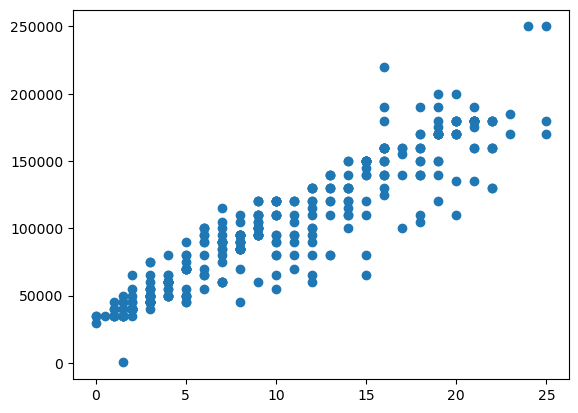

In [87]:
# let's plot
plt.scatter(X,y)

Let's do some pre-processing:

We're gonna normalize our input data X.

We're going to use ScikitLearn's MinMaxScaler(), which normalizes the data by scaling the features to a specified range, typically between 0 and 1, based on the minimum and maximum values present in the data.

In [88]:
# Create column transformer to apply transformations to specific columns
ct = make_column_transformer(
    (MinMaxScaler(), ["Years of Experience"]),  # Normalize "Years of Experience" column
    remainder='passthrough'  # Pass through columns not specified for transformation
)





# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)



# Transform training and test data with normalization (MinMaxScaler) and pass through the rest
X_train_transformed = ct.transform(X_train)
X_test_transformed = ct.transform(X_test)

<b>Note.</b> When you fit the transformer using X_train, you are essentially learning the parameters of the transformation based on the training data. This ensures that the transformation is applied consistently to both the training and testing data.

Fitting the transformer on the training data helps prevent data leakage, which can occur when information from the testing set inadvertently influences the model training process. It ensures that the preprocessing steps are learned solely from the training data, which reflects the real-world scenario where the model will be deployed on unseen data.

In [89]:
X_train_transformed.shape, y_train.shape

((298, 1), (298,))

In [90]:
X_train_transformed


y_train

193     95000.0
75      95000.0
84      40000.0
363     70000.0
16      90000.0
         ...   
71      70000.0
106     50000.0
272     90000.0
350    160000.0
102    150000.0
Name: Salary, Length: 298, dtype: float64

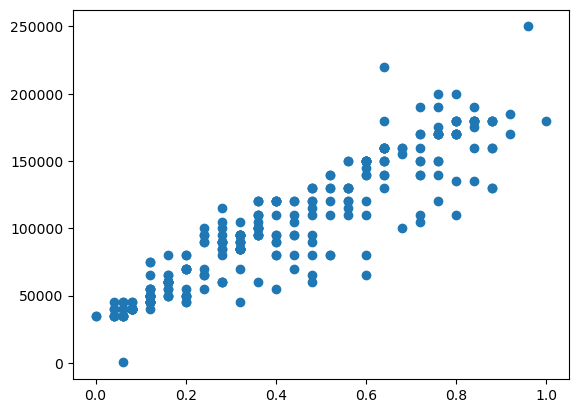

In [91]:
plt.scatter(X_train_transformed,y_train)

In [92]:
### Building our model

In [176]:
def build_model():
  model = keras.Sequential([
    layers.Dense(100,input_shape=[X_train_transformed.shape[1]]),
    layers.Dense(100),
      layers.Dense(150),
    tf.keras.layers.Dense(100),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [177]:
model = build_model()

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 100)               200       
                                                                 
 dense_61 (Dense)            (None, 100)               10100     
                                                                 
 dense_62 (Dense)            (None, 150)               15150     
                                                                 
 dense_63 (Dense)            (None, 100)               15100     
                                                                 
 dense_64 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40651 (158.79 KB)
Trainable params: 40651 (158.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We are going to configure validation_split, which indicates the fraction of data to be used as the validation set. In this case, 20% of the data will be used as the validation set, and the remaining 80% will be used as the training set

In [181]:
history = model.fit(
        X_train_transformed,y_train,
        validation_split=0.2,
        epochs=50,
        verbose=0
)

In [152]:
scores = model.evaluate(X_test_transformed, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 265570080.0000 - mae: 12849.0205 - mse: 265570080.0000


In [133]:
scores[1]

11434.8720703125

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline

# Create a linear regression model
baseline_model = LinearRegression()

# Fit the model on the training data
baseline_model.fit(X_train_transformed, y_train)

# Make predictions on the testing data
y_pred = baseline_model.predict(X_test_transformed)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

In [113]:
mae, mse

(12094.170341194764, 241834883.8999349)

In [119]:


mae - scores[1], mse - scores[2]



(-1740.8413775552362, -50964284.10006511)

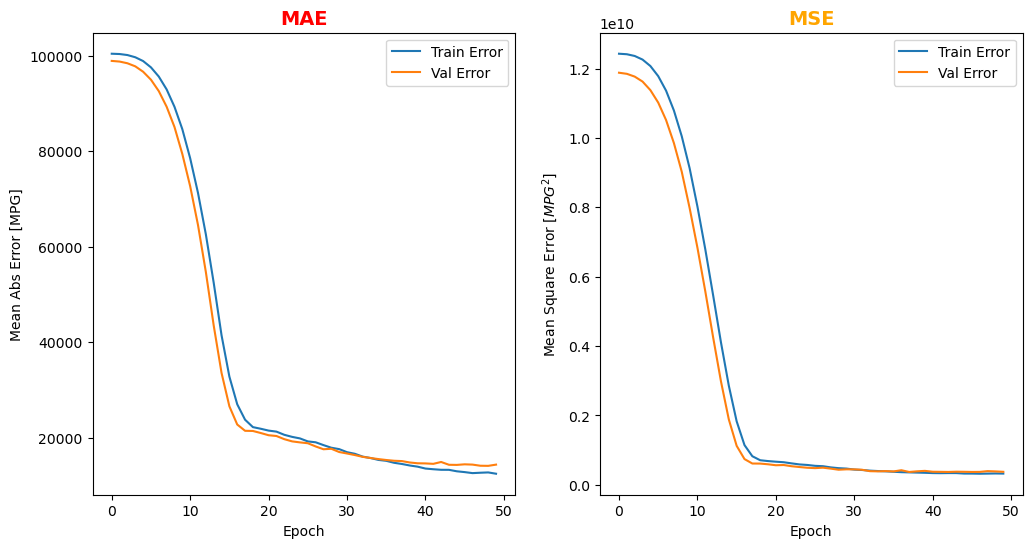

In [172]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns


    #plt.figure()
    axs[0].set_title('MAE',fontsize=14, fontweight='bold',color='red')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Mean Abs Error [MPG]')
    axs[0].plot(hist['epoch'], hist['mae'],
           label='Train Error')
    axs[0].plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    #plt.ylim([0,5])
    axs[0].legend()

    #plt.figure()
    axs[1].set_title('MSE',fontsize=14, fontweight='bold',color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Mean Square Error [$MPG^2$]')
    axs[1].plot(hist['epoch'], hist['mse'],
           label='Train Error')
    axs[1].plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    #plt.ylim([0,20])
    axs[1].legend()
    #axs[1].show()


plot_history(history)

In [196]:
# Assume 'input_data' is the input data you want to make predictions on
input_data = np.array([[5]])  # Example: 5 years of experience



data = {
    "Years of Experience": [5.0, 3.0]  # Example data for years of experience
}

# Create a pandas DataFrame
df = pd.DataFrame(data)


df


input_transformed = ct.transform(df)


# Transform the input data using the column transformer
#input_transformed = ct.transform(input_data)




# You may need to reshape the input data if it's a single feature
#input_normalized = input_normalized.reshape(-1, 1)

# Make predictions using the normalized input
prediction = model.predict(input_transformed)

1/1 [==============================] - 0s 69ms/step


In [197]:
prediction

array([[66221.37 ],
       [52039.637]], dtype=float32)